[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/mapelites.ipynb)

# JEDi: Quality with Just Enough Diversity

This notebook shows how to use QDax to find diverse and performing controllers in MDPs with [MAP-Elites](https://arxiv.org/abs/1504.04909).
It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create an emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process
- how to save/load a repertoire

In [1]:
#@title Installs and Imports
# !pip install ipympl |tail -n 1
# %matplotlib widget
# from google.colab import output
# output.enable_custom_widget_manager()

import os

from IPython.display import clear_output
import functools
import time

import jax
import jax.numpy as jnp

try:
    import brax
except:
    # !pip install git+https://github.com/google/brax.git@v0.0.15 |tail -n 1
    import brax

try:
    import qdax
except:
    # !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax


from qdax.core.map_elites import MAPElites
from qdax.core.custom_repertoire_mapelites import CustomMAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.core.containers.count_repertoire import CountMapElitesRepertoire, count_qd_metrics

from qdax import environments
from qdax.tasks.brax_envs import scoring_function_brax_envs as scoring_function
from qdax.tasks.brax_envs import reset_based_scoring_function_brax_envs

from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results

from qdax.utils.metrics import CSVLogger, default_qd_metrics

from jax.flatten_util import ravel_pytree

from IPython.display import HTML
from brax.io import html



if "COLAB_TPU_ADDR" in os.environ:
  from jax.tools import colab_tpu
  colab_tpu.setup_tpu()


clear_output()

%matplotlib inline

In [2]:
def net_shape(net):
    return jax.tree_map(lambda x: x.shape, net)

In [3]:
#@title QD Training Definitions Fields
#@markdown ---
batch_size = 100 #@param {type:"number"}
env_name = 'pointmaze' #@param['ant_uni', 'hopper_uni', 'walker2d_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
# env_name = 'pointmaze'#@param['ant_uni', 'hopper_uni', 'walker2d_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
episode_length = 1000 #@param {type:"integer"}
num_iterations = 1000 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
policy_hidden_layer_sizes = (64, 64) #@param {type:"raw"}
iso_sigma = 0.005 #@param {type:"number"}
line_sigma = 0.05 #@param {type:"number"}
num_init_cvt_samples = 50000 #@param {type:"integer"}
num_centroids = 1024 #@param {type:"integer"}
# num_centroids = 8192 #@param {type:"integer"}
min_bd = 0.0 #@param {type:"number"}
max_bd = 1.0 #@param {type:"number"}
#@markdown ---

In [4]:
plot_maze = False
if env_name == "pointmaze":
    min_bd = -1.0
    episode_length = 100
    plot_maze = True

if env_name == "antmaze":
    min_bd, max_bd = [-5, 40]
    episode_length = 250
    plot_maze = False

In [5]:
robert = False
if robert:
    policy_hidden_layer_sizes = (32,) * 4
    activation = jnp.tanh
else:
    policy_hidden_layer_sizes = (64, 64)
    activation = jax.nn.relu

print(policy_hidden_layer_sizes)

(64, 64)


## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [6]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)

# Init a random key
random_key = jax.random.PRNGKey(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
    activation=activation,
)

# Init population of controllers
random_key, subkey = jax.random.split(random_key)
keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)


# Create the initial environment states
random_key, subkey = jax.random.split(random_key)
keys = jnp.repeat(jnp.expand_dims(subkey, axis=0), repeats=batch_size, axis=0)
reset_fn = jax.jit(jax.vmap(env.reset))
init_states = reset_fn(keys)

## Define the way the policy interacts with the env

Now that the environment and policy has been defined, it is necessary to define a function that describes how the policy must be used to interact with the environment and to store transition data.

In [7]:
# Define the fonction to play a step with the policy in the environment
def play_step_fn(
  env_state,
  policy_params,
  random_key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)
    
    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, random_key, transition

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and behavior descriptor of each individual. 

In [8]:
# Prepare the scoring function
bd_extraction_fn = environments.behavior_descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function,
    init_states=init_states,
    episode_length=episode_length,
    play_step_fn=play_step_fn,
    behavior_descriptor_extractor=bd_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
# metrics_function = functools.partial(
#     default_qd_metrics,
#     qd_offset=reward_offset * episode_length,
# )
metrics_function = functools.partial(
    count_qd_metrics,
    qd_offset=reward_offset * episode_length,
)


## Define the emitter

The emitter is used to evolve the population at each mutation step.

In [9]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)
mixing_emitter = MixingEmitter(
    mutation_fn=None, 
    variation_fn=variation_fn, 
    variation_percentage=1.0, 
    batch_size=batch_size
)

## Instantiate and initialise the MAP Elites algorithm

In [10]:
# Instantiate MAP-Elites
map_elites = CustomMAPElites(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
    repertoire_type=CountMapElitesRepertoire,
)

# Compute the centroids
centroids, random_key = compute_cvt_centroids(
    num_descriptors=env.behavior_descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_bd,
    maxval=max_bd,
    random_key=random_key,
)

# Compute initial repertoire and emitter state
init_repertoire, emitter_state, random_key = map_elites.init(init_variables, centroids, random_key)
repertoire = init_repertoire

/home/paul/Dev/QDax/qdax/core/custom_repertoire_mapelites.py:67: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = self.repertoire_type.init(


In [11]:
init_metrics = metrics_function(init_repertoire)
list(init_metrics.keys())

['qd_score',
 'max_fitness',
 'coverage',
 'min_count',
 'max_count',
 'mean_count',
 'median_count',
 'std_count']

## Launch MAP-Elites iterations

In [12]:
log_period = 50
num_loops = int(num_iterations / log_period)

csv_logger = CSVLogger(
    "mapelites-logs.csv",
    header=["loop", "iteration", "time"] + list(init_metrics.keys()),
)
all_metrics = {}
repertoire = init_repertoire

from tqdm import tqdm
# main loop
map_elites_scan_update = map_elites.scan_update
for i in tqdm(range(num_loops)):
    start_time = time.time()
    # main iterations
    (repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, random_key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time

    # log metrics
    logged_metrics = {"time": timelapse, "loop": 1+i, "iteration": 1 + i*log_period}
    for key, value in metrics.items():
        # take last value
        logged_metrics[key] = value[-1]

        # take all values
        if key in all_metrics.keys():
            all_metrics[key] = jnp.concatenate([all_metrics[key], value])
        else:
            all_metrics[key] = value

    csv_logger.log(logged_metrics)

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


In [13]:
end_repertoire = repertoire

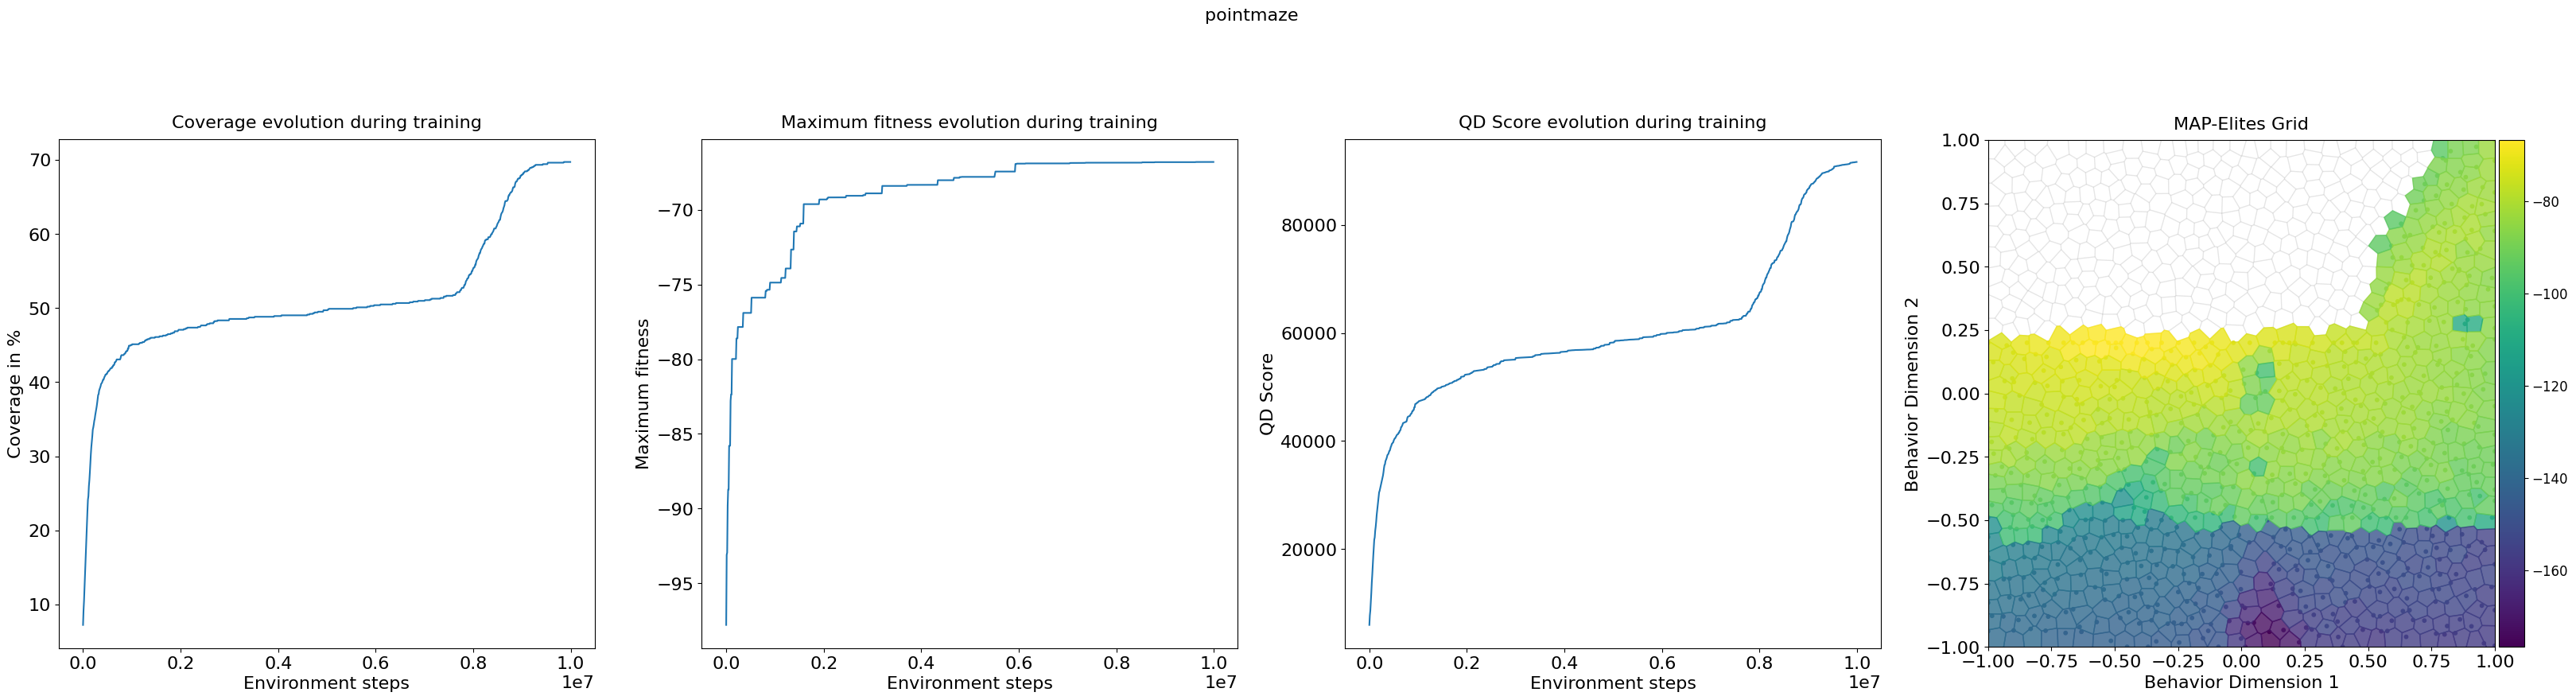

In [15]:
#@title Visualization

# create the x-axis array
env_steps = jnp.arange(num_iterations) * episode_length * batch_size

# create the plots and the grid
import matplotlib.pyplot as plt
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=all_metrics, repertoire=end_repertoire, min_bd=min_bd, max_bd=max_bd)
# general title
fig.suptitle(env_name, fontsize=16);
# plt.title(env_name)

In [18]:
fig.savefig(f"plots/ME_{env_name}_{episode_length}_{num_centroids}.png", dpi=300, bbox_inches="tight")

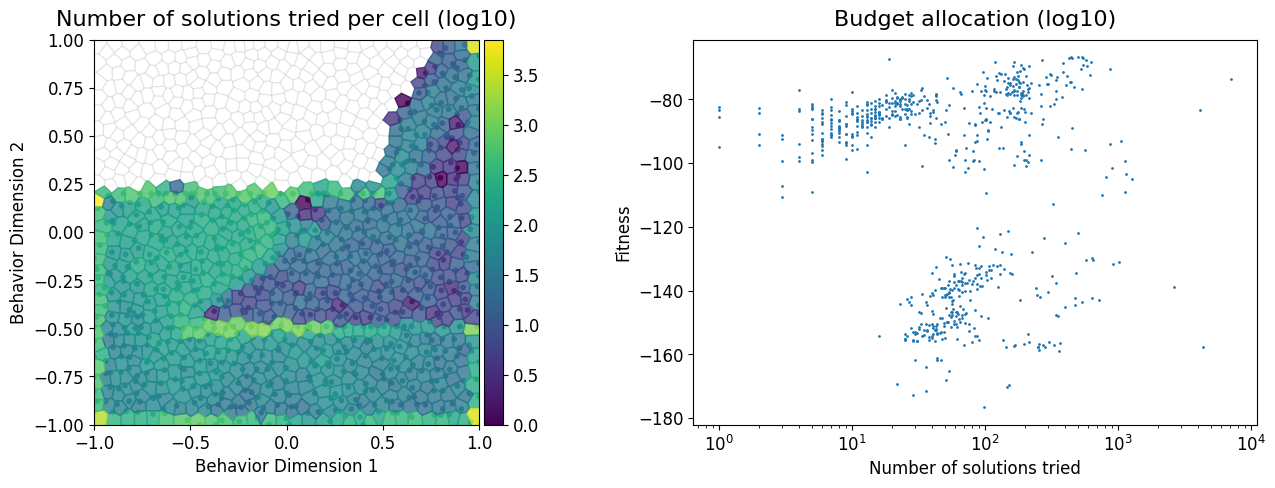

In [18]:
from qdax.jedi.plotting import plot_2d_count, scatter_count
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0] = plot_2d_count(end_repertoire, min_bd, max_bd, log_scale=True, ax=axes[0])
axes[1] = scatter_count(end_repertoire, log_scale=True, ax=axes[1])

In [19]:
end_repertoire.fitnesses.max()

Array(-66.78294, dtype=float32)

## Gaussian process

In [20]:
from qdax.jedi.gaussian_process import fit_GP, plot_GP

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: >

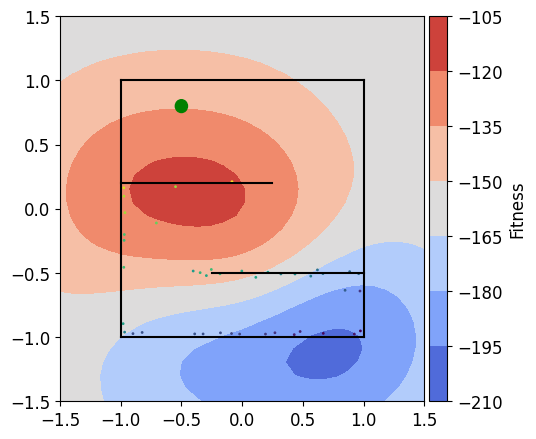

In [23]:
repertoire = init_repertoire
opt_posterior, D = fit_GP(repertoire, num_iters=1000)
plot_GP(repertoire, opt_posterior, grid_size=30, plot_std=False, larger=True, maze=plot_maze, min_bd=-1, max_bd=1)

## BD selection
### Pareto front
- Pareto front on mean and std
    - Mean: resample potentially good solutions
    - Std: sample zones not explored yet

In [34]:
from qdax.jedi.pareto import centroids_pareto, archive_pareto, crowded, crowded_centroids_pareto

### Descriptor crowding

/home/paul/Dev/QDax/qdax/jedi/pareto.py:17: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  points = points.astype(jnp.float64)


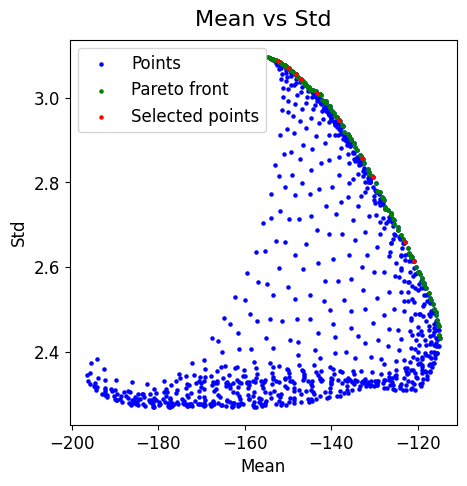

In [25]:
bounds = [[min_bd, max_bd]] * 2
front = centroids_pareto(repertoire, opt_posterior, D, bounds, n_points=10, plot=True, return_front=True)

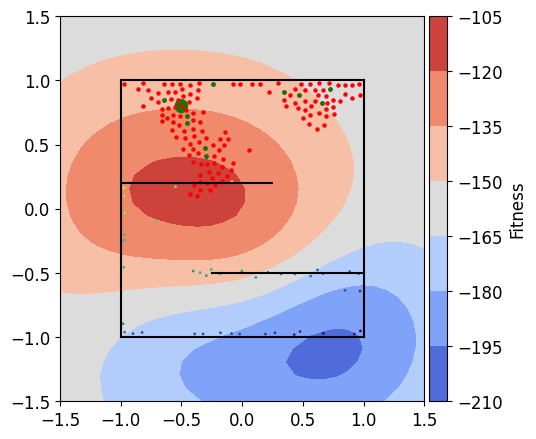

In [26]:
# fig, ax = plt.subplots(figsize=(5, 5))
# Get 10 random points of the Pareto front
rng = jax.random.PRNGKey(0)
selected = jax.random.choice(rng, front.shape[0], shape=(10,), replace=False)

ax = plot_GP(repertoire, opt_posterior, grid_size=30, plot_std=False, larger=True, maze=add_maze, min_bd=-1, max_bd=1)
ax.scatter(front[:, 0], front[:, 1], color="r", s=5, label="Pareto front")
ax.scatter(front[selected, 0], front[selected, 1], color="g", s=5, label="Random points")

/home/paul/Dev/QDax/qdax/jedi/pareto.py:17: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  points = points.astype(jnp.float64)


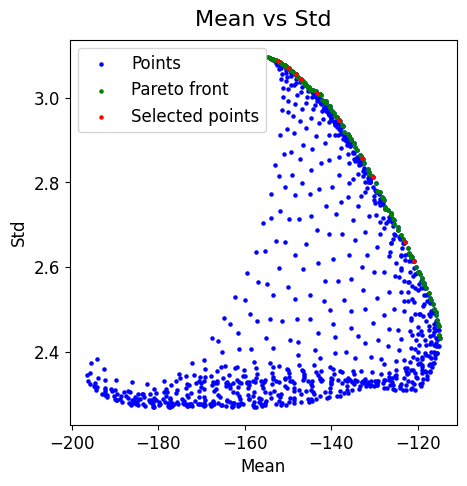

In [27]:
bounds = [[min_bd, max_bd]] * 2
targets = crowded_centroids_pareto(repertoire, opt_posterior, D, bounds, n_points=10, plot=True, return_front=False)

In [28]:
targets.shape

(10, 2)

### GP-UCB

In [29]:
from qdax.jedi.ucb import gp_ucb

/home/paul/Dev/QDax/qdax/jedi/ucb.py:4: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  points = repertoire.centroids.astype(jnp.float64)


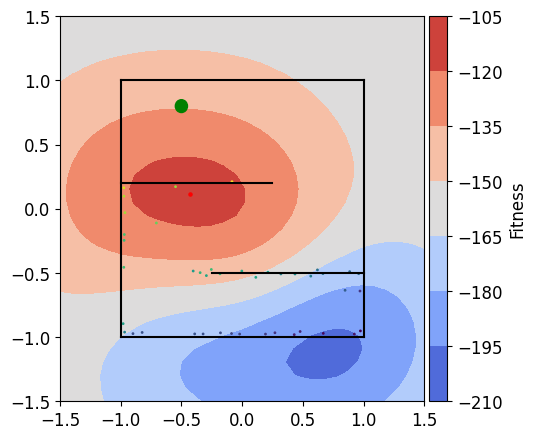

In [30]:
bounds = [[min_bd, max_bd]] * 2
ucb_beta = 1
targets = gp_ucb(repertoire, opt_posterior, D, ucb_beta, bounds, n_points=1, plot=True)

ax = plot_GP(repertoire, opt_posterior, grid_size=30, plot_std=False, larger=True, maze=add_maze, min_bd=-1, max_bd=1)
# Scatter targets
ax.scatter(targets[:, 0], targets[:, 1], color="r", s=5, label="Targets")

## Evolution Strategies

In [31]:
from qdax.jedi.evolution_strategies.base_es import BD_ES, Fitness_ES
from qdax.jedi.evolution_strategies.aria_es import MixedES

### Get starting point

In [32]:
from qdax.jedi.jedi_loop import closest_genotype, aim_for

# Main algo loop

In [33]:
reward_offset

2.3431

Logging initial archive
Not doing actor injection
layer_shapes [(64,), (2, 64), (64,), (64, 64), (2,), (64, 2)]
sizes [  64  128   64 4096    2  128]
layer_sizes [64, 128, 64, 4096, 2, 128]
split_indices [64, 192, 256, 4352, 4354]
Not doing actor injection
layer_shapes [(64,), (2, 64), (64,), (64, 64), (2,), (64, 2)]
sizes [  64  128   64 4096    2  128]
layer_sizes [64, 128, 64, 4096, 2, 128]
split_indices [64, 192, 256, 4352, 4354]
Fitting GP...


/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

Exploration ES


/home/paul/Dev/QDax/qdax/jedi/pareto.py:17: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  points = points.astype(jnp.float64)


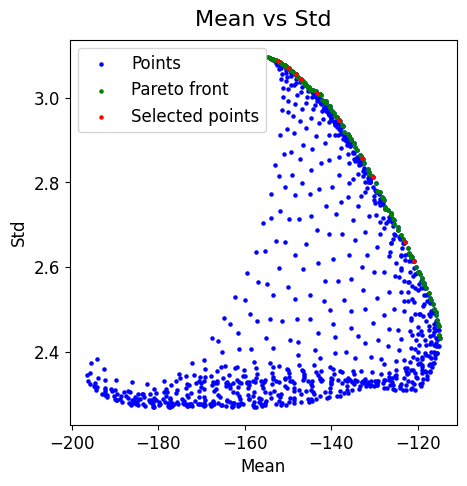

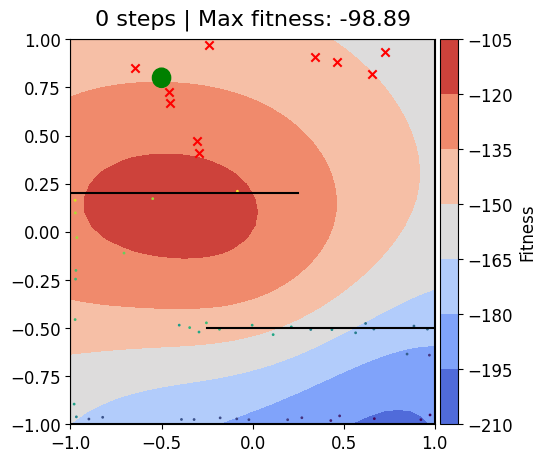

ES time: 42.18s
Max fitness: -34.671173095703125
Adding new genotypes to repertoire
Logging results
Fitting GP...


  0%|          | 0/1000 [00:00<?, ?it/s]

Exploitation ES
(9,) (1,)
(10,)


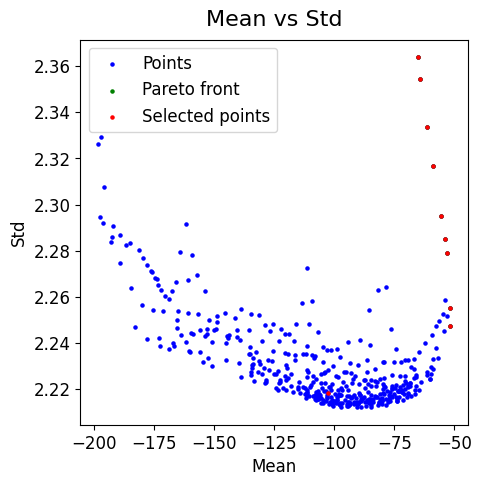

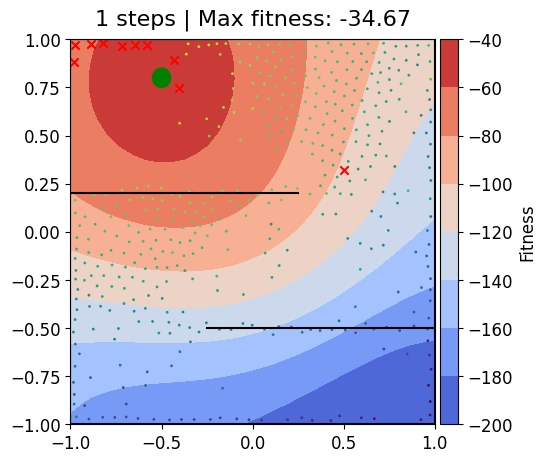

ES time: 40.47s
Max fitness: -22.8498477935791
Adding new genotypes to repertoire
Logging results
Fitting final GP


/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/ipykernel/comm/comm.py:79: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

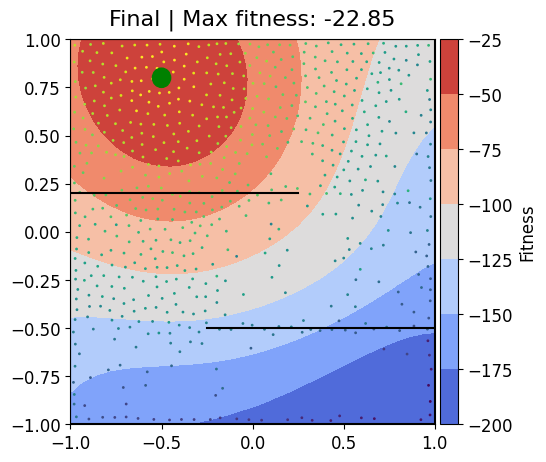

In [35]:
from time import time

# Algo loop
bounds = [[min_bd, max_bd]] * 2
qd_offset = reward_offset * episode_length
macro_loops = 2
target_nb = 10
larger = False
mixed = False
crowding = False

config = {
    "env_name": env_name,
    "episode_length": episode_length,
    "sample_number" : 10,
    "sigma" : 0.1, 
    "es_gens" : 1000,
}

random_key = jax.random.PRNGKey(0)

# Init repertoire
repertoire = init_repertoire

print("Logging initial archive")
loop = 0
logs = {
    "steps": [],
    "evaluations": [],
    "frames" : [],
    "max_fitness": [],
    "coverage": [],
    "qd_score": []
}
repertoire_empty = repertoire.fitnesses == -jnp.inf
initial_evals = sum(~repertoire_empty)

logs["steps"].append(loop)
evals = loop * target_nb * config["es_gens"] * (config["sample_number"]) + initial_evals
logs["evaluations"].append(evals)
logs["frames"].append(evals * episode_length)

qd_score = jnp.sum(repertoire.fitnesses, where=~repertoire_empty)
logs["qd_score"].append(qd_score + reward_offset * jnp.sum(1.0 - repertoire_empty))
logs["coverage"].append(100 * jnp.mean(1.0 - repertoire_empty))
logs["max_fitness"].append(jnp.max(repertoire.fitnesses))

# ES
if mixed:
    bd_es = MixedES(env, config)
else:
    bd_es = BD_ES(env, config)
base_bd_es_emitter_state, base_random_key = bd_es.init(policy_network)

fit_es = Fitness_ES(env, config)
base_fit_es_emitter_state, base_random_key = fit_es.init(policy_network)

explor_pareto = centroids_pareto
exploit_pareto = archive_pareto

if crowding:
    explor_pareto = crowded(explor_pareto)
    exploit_pareto = crowded(exploit_pareto)


for loop in range(1, macro_loops + 1):
    max_fitness = jnp.max(repertoire.fitnesses)
    # Fit GP to repertoire
    print("Fitting GP...")
    opt_posterior, train_data = fit_GP(repertoire)
    # print("Done.")

    if loop % 2:
        print("Exploration ES")
        es = bd_es
        base_es_emitter_state = base_bd_es_emitter_state
        target_bd = explor_pareto(
            repertoire, 
            opt_posterior, 
            train_data, 
            bounds, 
            n_points=target_nb,
            plot=True
            )

    else:
        print("Exploitation ES")
        es = fit_es
        base_es_emitter_state = base_fit_es_emitter_state
        target_bd = exploit_pareto(
            repertoire, 
            opt_posterior, 
            train_data, 
            bounds, 
            n_points=target_nb,
            plot=True
            )

    # print(f"Targets: {target_bd}")
    # Scatter targets
    ax = plot_GP(repertoire, opt_posterior, grid_size=30, larger=larger, maze=plot_maze, min_bd=min_bd, max_bd=max_bd)
    ax.scatter(target_bd[:, 0], target_bd[:, 1], c="r", marker="x")
    ax.set_title(f"{loop-1} steps | Max fitness: {max_fitness:.2f}")
    plt.show()

    # vmap on targets
    t0 = time()
    metrics, es_emitter_state, random_key = jax.vmap(
        lambda target: aim_for(
            target,
            repertoire,
            es,
            config,
            base_es_emitter_state,
            random_key,
    ))(target_bd)
    print(f"ES time: {time() - t0:.2f}s")

    random_key = random_key[0]
    
    fitnesses = metrics["population_fitness"].reshape(-1)
    descriptors = metrics["population_descriptors"].reshape(-1, 2)
    genotypes = metrics["population_networks"]
     # Concatenate on first 2 dimensions
    genotypes = jax.tree_map(
        lambda x: x.reshape(-1, *x.shape[3:]),
        genotypes
    )
    # shapes
    # print("Pop Shapes")
    # print(fitnesses.shape)
    # print(descriptors.shape)
    # print(net_shape(genotypes))

    # # reshape metrics (-1, 2)*
    # fitnesses = metrics["fitness"].reshape(-1)
    # descriptors = metrics["descriptor"].reshape(-1, 2)
    # genotypes = metrics["genotype"]

    # # Concatenate on first 2 dimensions
    # genotypes = jax.tree_map(
    #     lambda x: x.reshape(-1, *x.shape[2:]),
    #     genotypes
    # )

    # print("Center Shapes")
    # print(fitnesses.shape)
    # print(descriptors.shape)
    # print(net_shape(genotypes))
    

    print(f"Max fitness: {fitnesses.max()}")
    # print(net_shape(genotypes))

    # # Add new genotypes to repertoire
    print("Adding new genotypes to repertoire")
    repertoire = repertoire.add(genotypes, descriptors, fitnesses)

    # Log
    print("Logging results")
    logs["steps"].append(loop)
    evals = loop * target_nb * config["es_gens"] * (config["sample_number"])
    logs["evaluations"].append(evals)
    logs["frames"].append(evals * episode_length)

    repertoire_empty = repertoire.fitnesses == -jnp.inf
    qd_score = jnp.sum(repertoire.fitnesses, where=~repertoire_empty)
    logs["qd_score"].append(qd_score + qd_offset * jnp.sum(1.0 - repertoire_empty))
    logs["coverage"].append(100 * jnp.mean(1.0 - repertoire_empty))
    logs["max_fitness"].append(jnp.max(repertoire.fitnesses))
        
print("Fitting final GP")
opt_posterior, train_data = fit_GP(repertoire)
ax = plot_GP(repertoire, opt_posterior, grid_size=30, larger=larger, maze=plot_maze, min_bd=min_bd, max_bd=max_bd)
max_fitness = jnp.max(repertoire.fitnesses)
ax.set_title(f"Final | Max fitness: {max_fitness:.2f}")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

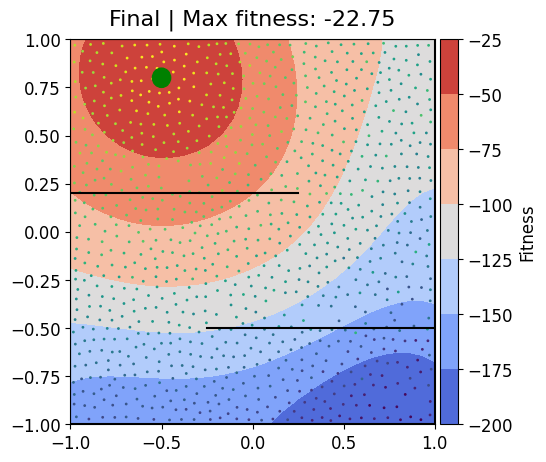

In [58]:
opt_posterior, train_data = fit_GP(repertoire)
ax = plot_GP(repertoire, opt_posterior, grid_size=30, larger=larger, maze=plot_maze, min_bd=min_bd, max_bd=max_bd)
max_fitness = jnp.max(repertoire.fitnesses)
ax.set_title(f"Final | Max fitness: {max_fitness:.2f}")
plt.show()

In [38]:
from qdax.jedi.plotting import plot_jedi_results

import qdax.jedi.plotting as work_file
import importlib
importlib.reload(work_file)
plot_jedi_results = work_file.plot_jedi_results

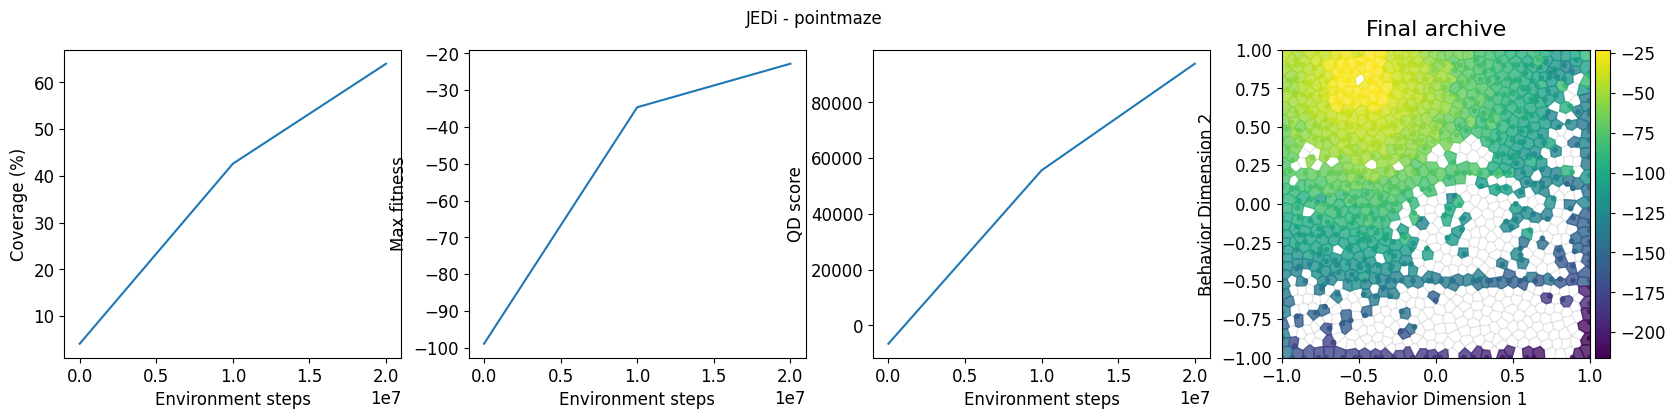

In [40]:
title = f"JEDi - {env_name}"
plot_jedi_results(repertoire, logs, title, min_bd, max_bd, log_scale=True);

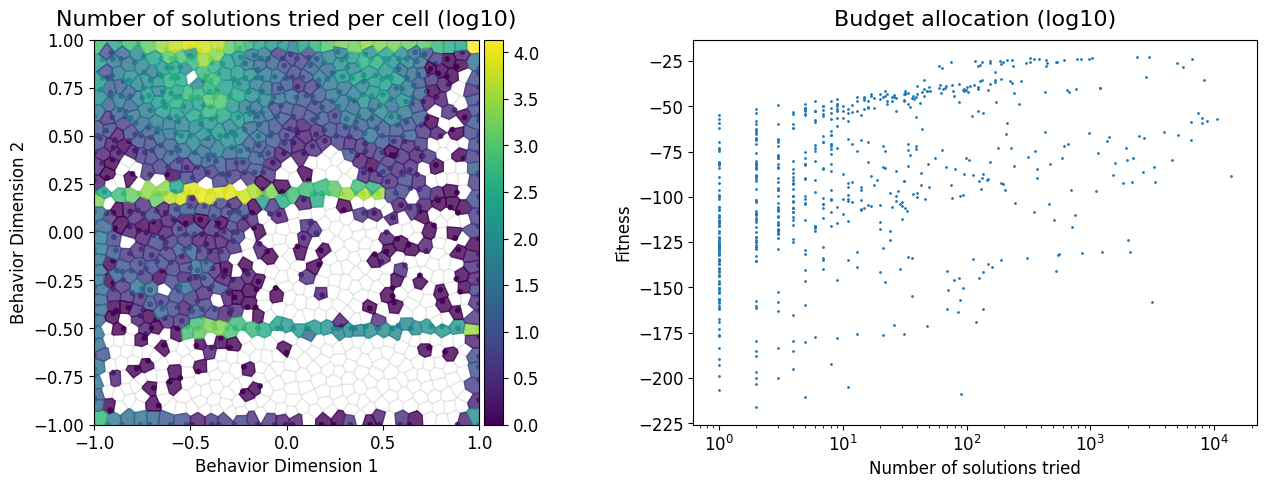

In [41]:
from qdax.jedi.plotting import plot_2d_count, scatter_count
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0] = plot_2d_count(repertoire, min_bd, max_bd, log_scale=True, ax=axes[0])
axes[1] = scatter_count(repertoire, log_scale=True, ax=axes[1])

Text(0, 0.5, 'Fitness')

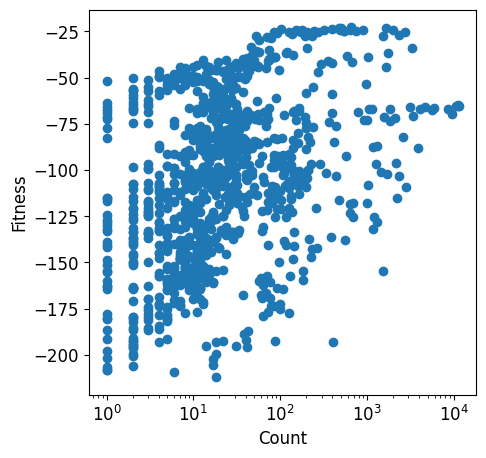

In [63]:
is_empty = repertoire.fitnesses == -jnp.inf
# counts
counts = repertoire.count[~is_empty]
# fitnesses
fitnesses = repertoire.fitnesses[~is_empty]

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(counts, fitnesses)
plt.xscale("log")
plt.xlabel("Count")
plt.ylabel("Fitness")

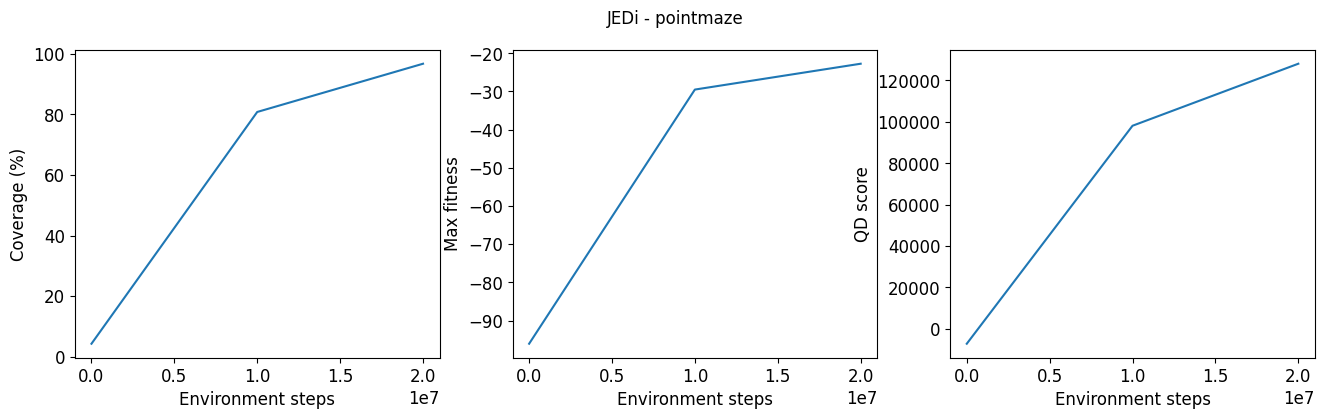

In [62]:
import matplotlib.pyplot as plt
# Plot results
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
x_axis = 'frames'
x_label = 'Environment steps'
plt.suptitle(f"JEDi - {env_name}")
ax[0].plot(logs[x_axis], logs["coverage"])
ax[0].set_xlabel(x_label)
ax[0].set_ylabel("Coverage (%)")
ax[1].plot(logs[x_axis], logs["max_fitness"])
ax[1].set_xlabel(x_label)
ax[1].set_ylabel("Max fitness")
ax[2].plot(logs[x_axis], logs["qd_score"])
ax[2].set_xlabel(x_label)
ax[2].set_ylabel("QD score")
plt.show()

In [ ]:
fig.savefig(f"plots/JEDi_{env_name}_{episode_length}_{num_centroids}.png", dpi=300, bbox_inches="tight")

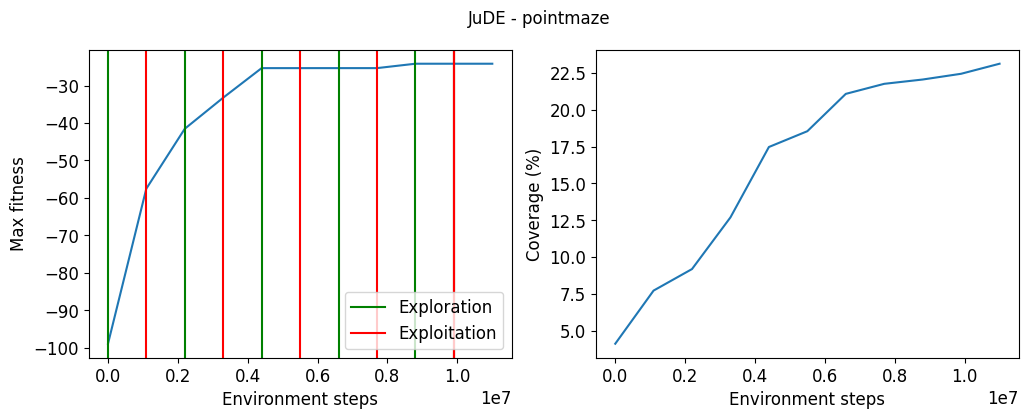

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
x_axis = 'frames'
x_label = 'Environment steps'
plt.suptitle(f"JuDE - {env_name}")
ax[0].plot(logs[x_axis], logs["max_fitness"])
ax[0].set_xlabel(x_label)
ax[0].set_ylabel("Max fitness")
ax[1].plot(logs[x_axis], logs["coverage"])
ax[1].set_xlabel(x_label)
ax[1].set_ylabel("Coverage (%)")
for i, x in enumerate(logs[x_axis][:-1]):
    if i%2:
        # Red vertical line
        ax[0].axvline(x, c="r")
    else:
        # green vertical line
        ax[0].axvline(x, c="g")
# Add legend: green = explore, red = exploit
ax[0].axvline(x, c="g", label="Exploration")
ax[0].axvline(x, c="r", label="Exploitation")
# bottom right
ax[0].legend(loc="lower right")
plt.show()


In [41]:
me_rep = end_repertoire
jude_rep = repertoire

In [45]:
centroids = jude_rep.descriptors.astype(jnp.float32)
# Evaluate GP on all centroids
latent_dist = opt_posterior.predict(centroids, train_data=train_data)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

/home/paul/miniconda3/envs/gpjax_env/lib/python3.9/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


In [46]:
is_empty = me_rep.fitnesses == -jnp.inf
gp_fitness = predictive_mean[~is_empty]
me_fitness = me_rep.fitnesses[~is_empty]

Text(0.5, 1.0, 'ME vs GP fitness')

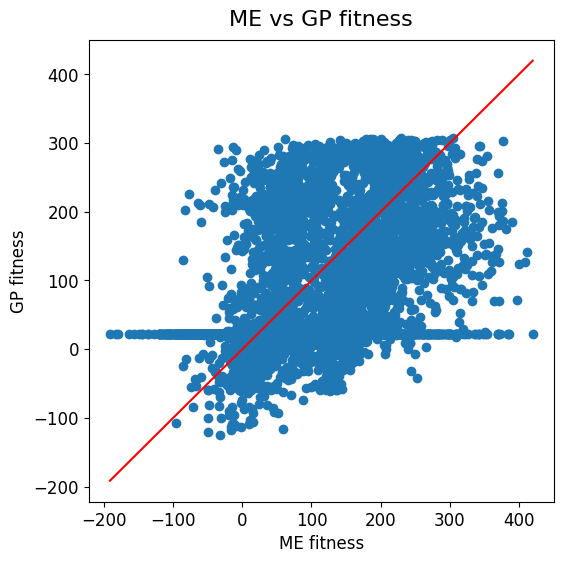

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.scatter(me_fitness, gp_fitness)
plt.xlabel("ME fitness")
plt.ylabel("GP fitness")
# plot y=x
x = jnp.linspace(jnp.min(me_fitness), jnp.max(me_fitness), 100)
plt.plot(x, x, c="r")
plt.title("ME vs GP fitness")

In [57]:
me_fitness

Array(-inf, dtype=float32)

Text(0.5, 1.0, 'ME vs GP fitness')

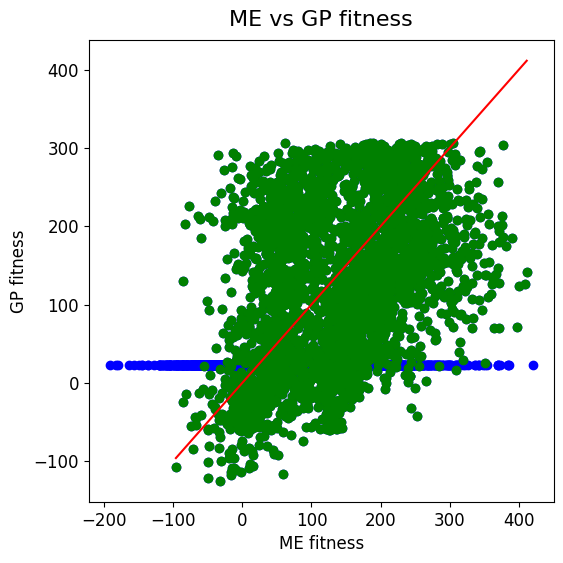

In [62]:
jude_empty = jude_rep.fitnesses == -jnp.inf
me_empty = me_rep.fitnesses == -jnp.inf
one_empty = jude_empty | me_empty

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

gp_fitness = predictive_mean[~me_empty]
me_fitness = me_rep.fitnesses[~me_empty]
ax.scatter(me_fitness, gp_fitness, c="b", label="ME")

gp_fitness = predictive_mean[~one_empty]
me_fitness = me_rep.fitnesses[~one_empty]
ax.scatter(me_fitness, gp_fitness, c="g", label="Both")

ax.set_xlabel("ME fitness")
ax.set_ylabel("GP fitness")
# plot y=x
x = jnp.linspace(jnp.min(me_fitness), jnp.max(me_fitness), 100)
ax.plot(x, x, c="r")
ax.set_title("ME vs GP fitness")

<Axes: >

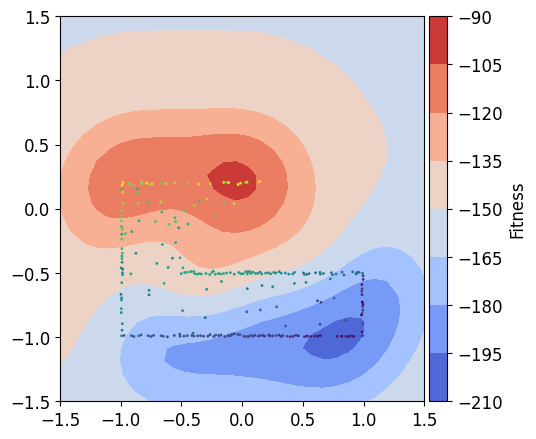

In [31]:
plot_GP(repertoire, opt_posterior, grid_size=30)

In [54]:
wall_width

(0.75, 0.75)